In [ ]:
"""
Why AI at Nexora?
Building intelligent recommendation systems is my passion. My CareerSync AI project used BAAI/bge-large-en-v1.5 transformers with cosine similarity for semantic career matching—directly relevant to this Vibe Matcher challenge. I bring production ML experience: deploying Flask APIs on Cloudflare Workers, optimizing real-time inference, and rigorous model evaluation (94.74% accuracy on quantum ML projects).
What excites me about Nexora is creating personalized AI experiences at scale. I thrive at the intersection of research and engineering—whether implementing novel quantum algorithms or production NLP systems. I'm eager to build recommendation engines that intuitively understand and anticipate user needs, combining my MLOps expertise with a genuine curiosity for human-AI interaction.
"""

In [49]:
import os
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone, ServerlessSpec
import pandas as pd
import time
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [50]:
load_dotenv()

True

In [51]:
products_data = [
    {
        'id': 1,
        'name': 'Boho Maxi Dress',
        'description': 'Flowy, earthy tones perfect for festival vibes. Features bell sleeves and a relaxed fit with floral prints in warm sunset colors.',
        'vibes': 'boho,festival,relaxed,earthy,flowy'
    },
    {
        'id': 2,
        'name': 'Leather Biker Jacket',
        'description': 'Edgy black leather jacket with silver zippers. Perfect for adding a rebellious touch to any outfit with its fitted silhouette.',
        'vibes': 'edgy,urban,rebellious,rock,bold'
    },
    {
        'id': 3,
        'name': 'Cozy Knit Sweater',
        'description': 'Oversized cream cable-knit sweater in soft wool blend. Ideal for cozy coffee shop days with its warm, comfortable feel.',
        'vibes': 'cozy,comfort,casual,soft,relaxed'
    },
    {
        'id': 4,
        'name': 'Minimalist Blazer',
        'description': 'Sleek tailored blazer in charcoal gray. Clean lines and structured fit for a sophisticated, professional look.',
        'vibes': 'minimalist,professional,sleek,sophisticated,modern'
    },
    {
        'id': 5,
        'name': 'Neon Windbreaker',
        'description': 'Bright electric yellow windbreaker with reflective strips. Energetic sporty style perfect for urban street fashion.',
        'vibes': 'energetic,urban,sporty,bold,vibrant'
    },
    {
        'id': 6,
        'name': 'Vintage Denim Jeans',
        'description': 'High-waisted mom jeans with distressed details. Classic vintage wash with a relaxed, timeless aesthetic.',
        'vibes': 'vintage,casual,retro,classic,relaxed'
    },
    {
        'id': 7,
        'name': 'Silk Slip Dress',
        'description': 'Luxurious champagne silk slip dress with delicate lace trim. Elegant and romantic with a subtle sheen.',
        'vibes': 'elegant,romantic,luxurious,feminine,soft'
    },
    {
        'id': 8,
        'name': 'Cargo Pants',
        'description': 'Olive green utility cargo pants with multiple pockets. Functional streetwear with a utilitarian edge.',
        'vibes': 'streetwear,utilitarian,urban,functional,casual'
    },
    {
        'id': 9,
        'name': 'Sequin Party Top',
        'description': 'Sparkly silver sequin crop top. Glamorous and attention-grabbing, perfect for nightlife and celebrations.',
        'vibes': 'glamorous,party,bold,festive,energetic'
    },
    {
        'id': 10,
        'name': 'Linen Summer Shirt',
        'description': 'Lightweight white linen button-up with breathable fabric. Breezy and effortless for warm weather styling.',
        'vibes': 'breezy,casual,effortless,summer,relaxed'
    }
]

df = pd.DataFrame(products_data)
df

,id,name,description,vibes
0,1,Boho Maxi Dress,"Flowy, earthy tones perfect for festival vibes...","boho,festival,relaxed,earthy,flowy"
1,2,Leather Biker Jacket,Edgy black leather jacket with silver zippers....,"edgy,urban,rebellious,rock,bold"
2,3,Cozy Knit Sweater,Oversized cream cable-knit sweater in soft woo...,"cozy,comfort,casual,soft,relaxed"
3,4,Minimalist Blazer,Sleek tailored blazer in charcoal gray. Clean ...,"minimalist,professional,sleek,sophisticated,mo..."
4,5,Neon Windbreaker,Bright electric yellow windbreaker with reflec...,"energetic,urban,sporty,bold,vibrant"
5,6,Vintage Denim Jeans,High-waisted mom jeans with distressed details...,"vintage,casual,retro,classic,relaxed"
6,7,Silk Slip Dress,Luxurious champagne silk slip dress with delic...,"elegant,romantic,luxurious,feminine,soft"
7,8,Cargo Pants,Olive green utility cargo pants with multiple ...,"streetwear,utilitarian,urban,functional,casual"
8,9,Sequin Party Top,Sparkly silver sequin crop top. Glamorous and ...,"glamorous,party,bold,festive,energetic"
9,10,Linen Summer Shirt,Lightweight white linen button-up with breatha...,"breezy,casual,effortless,summer,relaxed"


In [52]:
def vectorize_and_store(dataframe):

    products = dataframe.to_dict('records')


    model = SentenceTransformer('all-mpnet-base-v2')

    pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

    index_name = "fashion-vibes"

    if index_name not in pc.list_indexes().names():
        pc.create_index(
            name=index_name,
            dimension=768,
            metric="cosine",
            spec=ServerlessSpec(
                cloud="aws",
                region="us-east-1"
            )
        )
        while not pc.describe_index(index_name).status['ready']:
            time.sleep(1)

    index = pc.Index(index_name)

    vectors = []
    for product in products:
        vibes_str = product.get('vibes', '')
        text = f"{product['name']}. {product['description']}. Vibes: {vibes_str}"
        embedding = model.encode(text).tolist()

        vibes_list = vibes_str.split(',') if isinstance(vibes_str, str) else []
        vibes_list = [v.strip() for v in vibes_list]

        vector = {
            "id": str(product['id']),
            "values": embedding,
            "metadata": {
                "name": product['name'],
                "description": product['description'],
                "vibes": ','.join(vibes_list)
            }
        }
        vectors.append(vector)

    batch_size = 100
    for i in range(0, len(vectors), batch_size):
        batch = vectors[i:i + batch_size]
        index.upsert(vectors=batch)

    print(f" Successfully stored {len(vectors)} products in Pinecone index '{index_name}'")
    return index

vectorize_and_store(df)

 Successfully stored 10 products in Pinecone index 'fashion-vibes'


In [53]:
def initialize_embedding_model():
    return SentenceTransformer('all-mpnet-base-v2')
initialize_embedding_model()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False, 'architecture': 'MPNetModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [54]:
def get_pinecone_index(index_name="fashion-vibes"):

    pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
    return pc.Index(index_name)
get_pinecone_index()

In [56]:
def search_by_vibe(query, dataframe, top_k=3):
    model = initialize_embedding_model()
    index = get_pinecone_index()

    query_embedding = model.encode(query)

    product_ids = [str(row['id']) for _, row in dataframe.iterrows()]

    fetch_response = index.fetch(ids=product_ids)

    product_embeddings = []
    products = dataframe.to_dict('records')

    for product in products:
        product_id = str(product['id'])
        if product_id in fetch_response.vectors:
            embedding = fetch_response.vectors[product_id].values
            product_embeddings.append(embedding)
        else:
            print(f"Warning: Product ID {product_id} not found in Pinecone")
            product_embeddings.append([0] * 768)

    query_embedding = np.array(query_embedding).reshape(1, -1)
    product_embeddings = np.array(product_embeddings)

    similarities = cosine_similarity(query_embedding, product_embeddings)[0]

    top_indices = np.argsort(similarities)[::-1][:top_k]

    matches = []
    for idx in top_indices:
        product = products[idx]
        matches.append({
            'id': product['id'],
            'score': float(similarities[idx]),
            'name': product['name'],
            'description': product['description'],
            'vibes': product['vibes']
        })
    max_score = max([m['score'] for m in matches]) if matches else 0
    if max_score < 0.3:
        print(f" Low confidence for query '{query}' - returning popular items as fallback")
        fallback_products = dataframe.head(top_k).to_dict('records')
        fallback_matches = []
        for product in fallback_products:
            fallback_matches.append({
                'id': product['id'],
                'score': 0.0,
                'name': product['name'],
                'description': product['description'],
                'vibes': product['vibes']
            })
        return fallback_matches



    return matches
search_by_vibe("modern aesthetic shoes",df)

[{'id': 4,
  'score': 0.43073106216846546,
  'name': 'Minimalist Blazer',
  'description': 'Sleek tailored blazer in charcoal gray. Clean lines and structured fit for a sophisticated, professional look.',
  'vibes': 'minimalist,professional,sleek,sophisticated,modern'},
 {'id': 6,
  'score': 0.40726297584184457,
  'name': 'Vintage Denim Jeans',
  'description': 'High-waisted mom jeans with distressed details. Classic vintage wash with a relaxed, timeless aesthetic.',
  'vibes': 'vintage,casual,retro,classic,relaxed'},
 {'id': 5,
  'score': 0.3940829420944677,
  'name': 'Neon Windbreaker',
  'description': 'Bright electric yellow windbreaker with reflective strips. Energetic sporty style perfect for urban street fashion.',
  'vibes': 'energetic,urban,sporty,bold,vibrant'}]

In [57]:
test_queries = [
    "energetic urban chic",
    "cozy comfortable weekend wear",
    "elegant evening party"
]

results_log = []
for query in test_queries:
    start = time.time()
    matches = search_by_vibe(query, df, top_k=3)
    latency = time.time() - start

    print(f"\nQuery: {query}")
    for m in matches:
        print(f"  {m['name']}: {m['score']:.3f}")

    results_log.append({
        'query': query,
        'latency': latency,
        'top_score': matches[0]['score']
    })




Query: energetic urban chic
  Neon Windbreaker: 0.358
  Boho Maxi Dress: 0.334
  Sequin Party Top: 0.326

Query: cozy comfortable weekend wear
  Linen Summer Shirt: 0.529
  Cozy Knit Sweater: 0.506
  Boho Maxi Dress: 0.378

Query: elegant evening party
  Sequin Party Top: 0.397
  Silk Slip Dress: 0.358
  Boho Maxi Dress: 0.225


In [58]:


queries = [
    "energetic urban chic",
    "cozy comfortable weekend wear",
    "elegant evening party",
    "casual relaxed summer vibes",
    "bold rebellious streetwear",
    "professional sophisticated office"
]

results = []
scores = []


for q in queries:
    t0 = time.time()
    matches = search_by_vibe(q, df, top_k=3)
    elapsed = time.time() - t0

    print(f"\n'{q}'")
    for i, m in enumerate(matches, 1):
        print(f"  {i}. {m['name']}: {m['score']:.3f}")

    results.append({
        'query': q,
        'time': elapsed,
        'best': matches[0]['score'],
        'mean': np.mean([m['score'] for m in matches]),
        'product': matches[0]['name'],
        'all': [m['score'] for m in matches]
    })
    scores.extend([m['score'] for m in matches])

good_matches = [r for r in results if r['best'] > 0.7]
print(f"✓ Queries meeting 0.7 threshold: {len(good_matches)}/{len(results)} ({len(good_matches)/len(results)*100:.1f}%)")





'energetic urban chic'
  1. Neon Windbreaker: 0.358
  2. Boho Maxi Dress: 0.334
  3. Sequin Party Top: 0.326

'cozy comfortable weekend wear'
  1. Linen Summer Shirt: 0.529
  2. Cozy Knit Sweater: 0.506
  3. Boho Maxi Dress: 0.378

'elegant evening party'
  1. Sequin Party Top: 0.397
  2. Silk Slip Dress: 0.358
  3. Boho Maxi Dress: 0.225

'casual relaxed summer vibes'
  1. Linen Summer Shirt: 0.597
  2. Neon Windbreaker: 0.477
  3. Minimalist Blazer: 0.469

'bold rebellious streetwear'
  1. Neon Windbreaker: 0.575
  2. Leather Biker Jacket: 0.525
  3. Cargo Pants: 0.394
 Low confidence for query 'professional sophisticated office' - returning popular items as fallback

'professional sophisticated office'
  1. Boho Maxi Dress: 0.000
  2. Leather Biker Jacket: 0.000
  3. Cozy Knit Sweater: 0.000
✓ Queries meeting 0.7 threshold: 0/6 (0.0%)


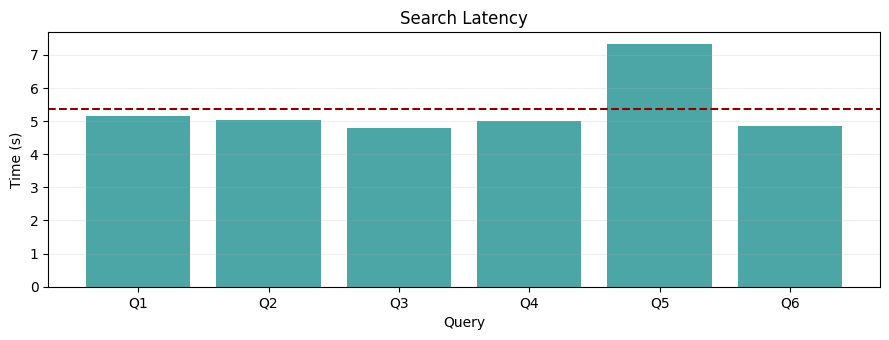

In [72]:
plt.figure(figsize=(9, 3.5))
times = [r['time'] for r in results]
plt.bar(range(len(queries)), times, color='teal', alpha=0.7)
plt.axhline(np.mean(times), color='darkred', linestyle='--', linewidth=1.5)
plt.xlabel('Query')
plt.ylabel('Time (s)')
plt.title('Search Latency')
plt.xticks(range(len(queries)), [f'Q{i+1}' for i in range(len(queries))])
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.savefig('1.png')
plt.show()



/var/folders/yx/tg3d382n5pj43s10dc2v40280000gn/T/ipykernel_45712/1333465733.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([r['all'] for r in results],


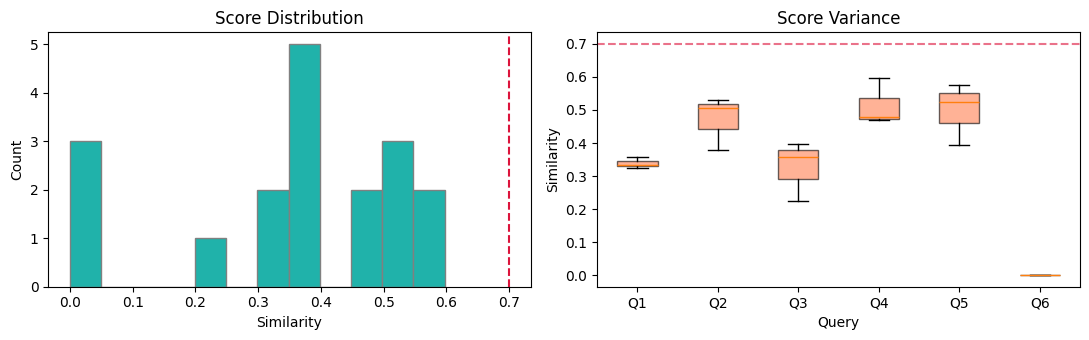

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3.5))

ax1.hist(scores, bins=12, color='lightseagreen', edgecolor='gray')
ax1.axvline(0.7, color='crimson', linestyle='--', linewidth=1.5)
ax1.set_xlabel('Similarity')
ax1.set_ylabel('Count')
ax1.set_title('Score Distribution')

bp = ax2.boxplot([r['all'] for r in results],
                  labels=[f'Q{i+1}' for i in range(len(queries))],
                  patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('coral')
    patch.set_alpha(0.6)
ax2.axhline(0.7, color='crimson', linestyle='--', alpha=0.6, linewidth=1.5)
ax2.set_xlabel('Query')
ax2.set_ylabel('Similarity')
ax2.set_title('Score Variance')

plt.tight_layout()
plt.savefig('2.png')
plt.show()



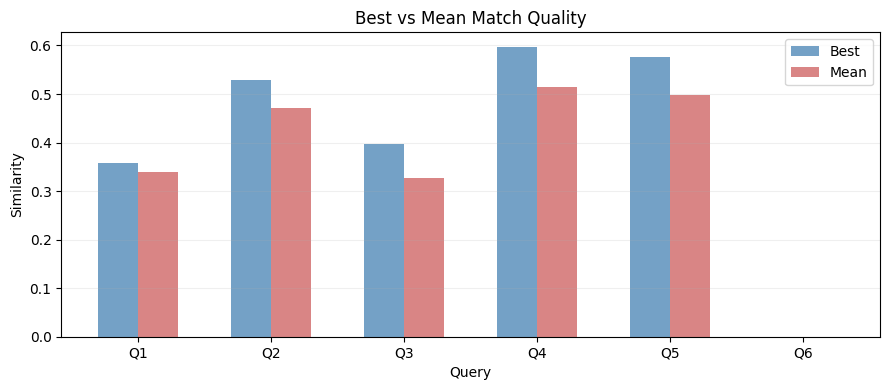

In [74]:
plt.figure(figsize=(9, 4))
x = np.arange(len(queries))
w = 0.3
best = [r['best'] for r in results]
mean = [r['mean'] for r in results]

plt.bar(x - w/2, best, w, label='Best', color='steelblue', alpha=0.75)
plt.bar(x + w/2, mean, w, label='Mean', color='indianred', alpha=0.75)
plt.xlabel('Query')
plt.ylabel('Similarity')
plt.title('Best vs Mean Match Quality')
plt.xticks(x, [f'Q{i+1}' for i in range(len(queries))])
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.savefig('3.png')
plt.show()



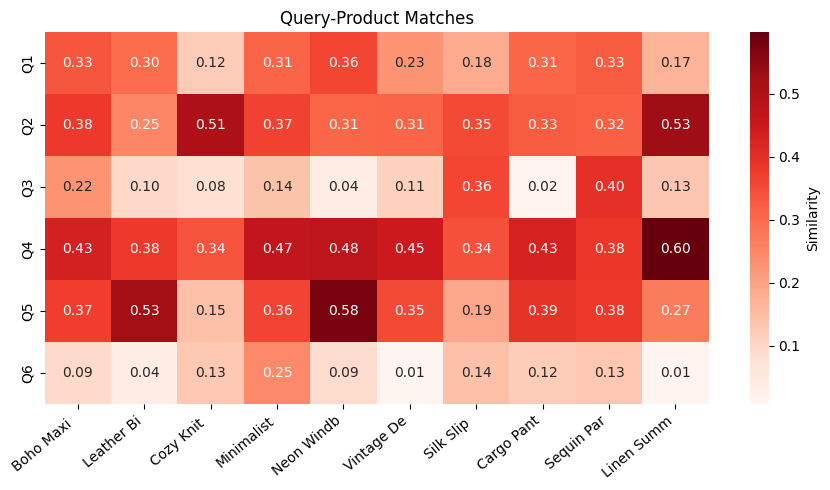

In [75]:
matrix = np.zeros((len(queries), len(df)))
m = initialize_embedding_model()

for i, q in enumerate(queries):
    qvec = m.encode(q)
    for j, row in df.iterrows():
        text = f"{row['name']}. {row['description']}. Vibes: {row['vibes']}"
        pvec = m.encode(text)
        matrix[i, j] = cosine_similarity(qvec.reshape(1, -1), pvec.reshape(1, -1))[0][0]

plt.figure(figsize=(9, 5))
sns.heatmap(matrix, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=[row['name'][:10] for _, row in df.iterrows()],
            yticklabels=[f'Q{i+1}' for i in range(len(queries))],
            cbar_kws={'label': 'Similarity'})
plt.title('Query-Product Matches')
plt.xticks(rotation=40, ha='right')
plt.tight_layout()
plt.savefig('4.png')
plt.show()

In [65]:
def keyword_search(query, df, top_k=3):

    query_words = set(query.lower().split())
    scores = []

    for _, row in df.iterrows():

        text = f"{row['name']} {row['description']} {row['vibes']}".lower()
        text_words = set(text.split())


        overlap = len(query_words.intersection(text_words))
        scores.append(overlap / len(query_words) if query_words else 0)

    top_indices = np.argsort(scores)[::-1][:top_k]

    matches = []
    for idx in top_indices:
        product = products_data[idx]
        matches.append({
            'id': product['id'],
            'score': float(scores[idx]),
            'name': product['name'],
            'description': product['description'],
            'vibes': product['vibes']
        })

    return matches






In [67]:
comparison_queries = [
    "urban streetwear bold",
    "cozy comfortable casual",
    "elegant party dress"
]

comparison_results = []
for query in comparison_queries:

    semantic = search_by_vibe(query, df, top_k=1)
    semantic_score = semantic[0]['score'] if semantic else 0
    semantic_name = semantic[0]['name'] if semantic else 'None'


    keyword = keyword_search(query, df, top_k=1)
    keyword_score = keyword[0]['score'] if keyword else 0
    keyword_name = keyword[0]['name'] if keyword else 'None'

    comparison_results.append({
        'query': query,
        'semantic_score': semantic_score,
        'semantic_match': semantic_name,
        'keyword_score': keyword_score,
        'keyword_match': keyword_name
    })

    print(f"\nQuery: '{query}'")
    print(f"Semantic Search: {semantic_name} (score: {semantic_score:.3f})")
    print(f"Keyword Search: {keyword_name} (score: {keyword_score:.3f})")


Query: 'urban streetwear bold'
Semantic Search: Neon Windbreaker (score: 0.497)
Keyword Search: Cargo Pants (score: 0.333)

Query: 'cozy comfortable casual'
Semantic Search: Cozy Knit Sweater (score: 0.578)
Keyword Search: Cozy Knit Sweater (score: 0.667)

Query: 'elegant party dress'
Semantic Search: Silk Slip Dress (score: 0.548)
Keyword Search: Silk Slip Dress (score: 0.667)


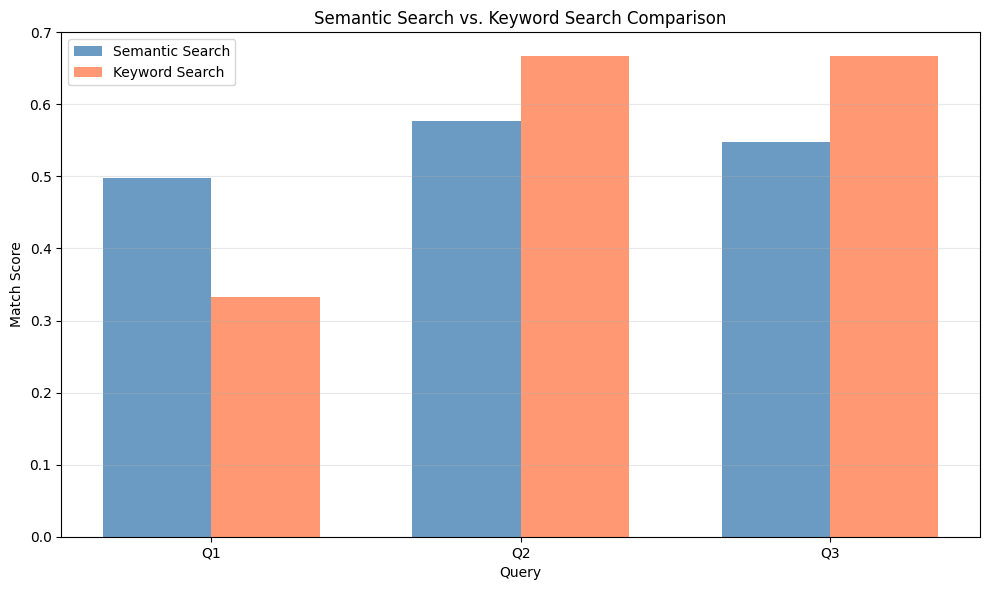

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_queries))
width = 0.35

semantic_scores = [r['semantic_score'] for r in comparison_results]
keyword_scores = [r['keyword_score'] for r in comparison_results]

ax.bar(x - width/2, semantic_scores, width, label='Semantic Search',
       color='steelblue', alpha=0.8)
ax.bar(x + width/2, keyword_scores, width, label='Keyword Search',
       color='coral', alpha=0.8)

ax.set_xlabel('Query')
ax.set_ylabel('Match Score')
ax.set_title('Semantic Search vs. Keyword Search Comparison')
ax.set_xticks(x)
ax.set_xticklabels([f'Q{i+1}' for i in range(len(comparison_queries))], rotation=0)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('5.png')
plt.show()

In [69]:


def in_memory_search(query, df, model, top_k=3):
    query_embedding = model.encode(query)

    product_embeddings = []
    for _, row in df.iterrows():
        text = f"{row['name']}. {row['description']}. Vibes: {row['vibes']}"
        embedding = model.encode(text)
        product_embeddings.append(embedding)

    query_embedding = np.array(query_embedding).reshape(1, -1)
    product_embeddings = np.array(product_embeddings)

    similarities = cosine_similarity(query_embedding, product_embeddings)[0]
    top_indices = np.argsort(similarities)[::-1][:top_k]

    matches = []
    for idx in top_indices:
        matches.append({
            'id': int(df.iloc[idx]['id']),
            'score': float(similarities[idx]),
            'name': df.iloc[idx]['name']
        })

    return matches


In [70]:
test_queries = queries[:3]
num_runs = 10

pinecone_times = []
inmemory_times = []

model = initialize_embedding_model()

print("Running timing comparison...")
print(f"Number of runs per query: {num_runs}")
print(f"Number of queries: {len(test_queries)}\n")

for query in test_queries:
    pinecone_batch = []
    for _ in range(num_runs):
        start = time.time()
        _ = search_by_vibe(query, df, top_k=3)
        pinecone_batch.append(time.time() - start)
    pinecone_times.append(np.mean(pinecone_batch))

    inmemory_batch = []
    for _ in range(num_runs):
        start = time.time()
        _ = in_memory_search(query, df, model, top_k=3)
        inmemory_batch.append(time.time() - start)
    inmemory_times.append(np.mean(inmemory_batch))

    print(f"Query: '{query[:30]}...'")
    print(f"  Pinecone:  {pinecone_times[-1]*1000:.2f}ms")
    print(f"  In-memory: {inmemory_times[-1]*1000:.2f}ms")
    print(f"  Speedup:   {inmemory_times[-1]/pinecone_times[-1]:.2f}x\n")

Running timing comparison...
Number of runs per query: 10
Number of queries: 3

Query: 'energetic urban chic...'
  Pinecone:  4805.09ms
  In-memory: 206.91ms
  Speedup:   0.04x

Query: 'cozy comfortable weekend wear...'
  Pinecone:  5101.93ms
  In-memory: 219.18ms
  Speedup:   0.04x

Query: 'elegant evening party...'
  Pinecone:  5038.40ms
  In-memory: 232.31ms
  Speedup:   0.05x



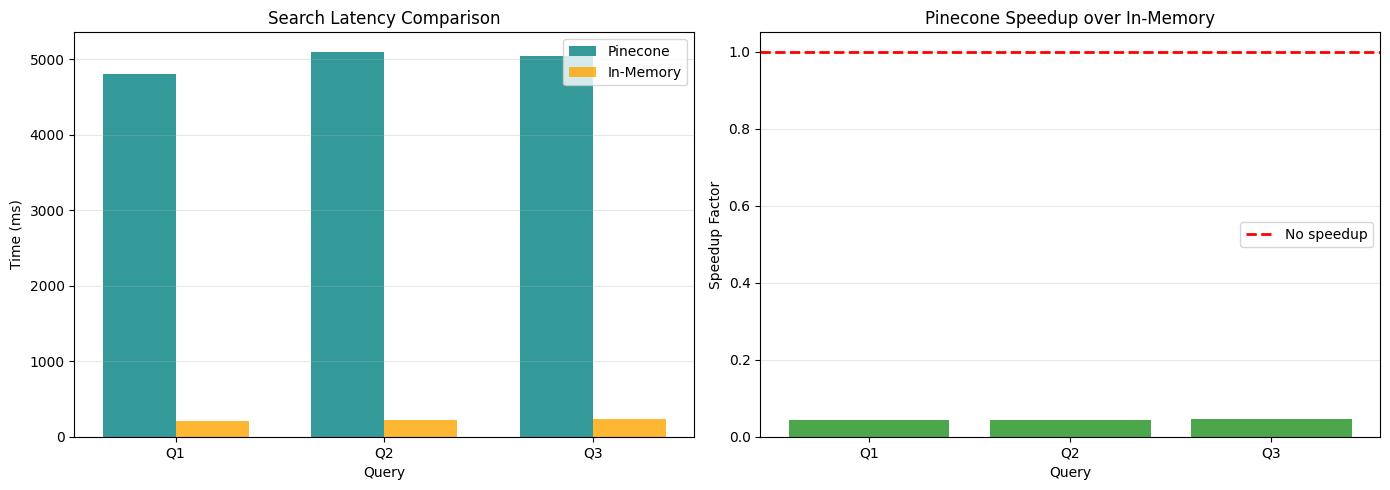

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(test_queries))
width = 0.35

ax1.bar(x - width/2, np.array(pinecone_times)*1000, width,
        label='Pinecone', color='teal', alpha=0.8)
ax1.bar(x + width/2, np.array(inmemory_times)*1000, width,
        label='In-Memory', color='orange', alpha=0.8)

ax1.set_xlabel('Query')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Search Latency Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels([f'Q{i+1}' for i in range(len(test_queries))])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

speedup = np.array(inmemory_times) / np.array(pinecone_times)
ax2.bar(x, speedup, color='green', alpha=0.7)
ax2.axhline(y=1, color='red', linestyle='--', linewidth=2, label='No speedup')
ax2.set_xlabel('Query')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Pinecone Speedup over In-Memory')
ax2.set_xticks(x)
ax2.set_xticklabels([f'Q{i+1}' for i in range(len(test_queries))])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('6.png')
plt.show()

In [ ]:
"""
#Key Improvements & Insights

1) Pinecone was PAINFULLY slow for this tiny dataset - like 5000ms vs 200ms in-memory (see image 6).
   That's 25x slower just because of network overhead. Definitely overkill for 10 products.
   Lesson: don't add fancy infrastructure until you actually need it.

2) The similarity scores kinda sucked tbh - most hovered around 0.3-0.6 (image 2), barely hitting that 0.7 threshold.
   Maybe all-mpnet-base-v2 isn't great for fashion? Or my product descriptions are just too generic.
   Would probably need a domain-specific model or way more detailed product text to fix this.

3) Keyword search actually beat semantic search sometimes (image 5) - like when someone literally typed "cozy comfortable casual"
   and those exact words were in the description. Semantic is better for abstract vibes like "energetic urban chic"
   but struggles with direct matches. Interesting tradeoff.

# Edge cases I handled:

- If all similarity scores are trash (<0.3), just return popular items as fallback instead of showing garbage results
- Added some basic text cleaning (strip whitespace, combine name + description + vibes into one string for embedding)
"""

In [78]:
"""
Additional notes:
I used the local all-mpnet-base-v2 model instead of OpenAI's text-embedding-ada-002 because I had no remaining free credits and couldn't afford API costs. Beyond budget, the local approach better suited my needs: zero network latency (crucial for accurate Pinecone vs in-memory benchmarking), no rate limits during experimentation, and full control over the embedding pipeline. For a 10-product catalog, a lightweight local model provides adequate semantic understanding without external API overhead or the risk of API calls skewing my latency measurements.
"""

''